In [20]:
import uuid
import random
import numpy as np
import pandas as pd
from linkage.column import Column
from linkage.dataset import Dataset
from linkage.repository import Repository

##### FILES THAT NEED TO BE COMBINED TOGETHER
- `audience.csv` (raw data)
- `audience_populated.csv` (for node vectors)

- `age_categories.csv` (for constructing graph)
- `audience_categories.csv` (for constructing graph)
- `categorical_buckets.csv` (for constructing graph)
- `interest_categories.csv` (for constructing graph)

In [21]:
PATH = '../data/SocialTalk'
SEPARATOR = ','
TABLE = 'audience.csv'

In [22]:
def convert(x):
    try:
        return float(x)
    except:
        return np.nan

In [23]:
df = pd.read_csv(f'{PATH}/{TABLE}', sep=SEPARATOR, low_memory=False)
valid_data = df[df['Audience credibility'].apply(convert) >= 0.5]
valid_data.head()

,Social network,Username,Name,Country,City,Birthdate,Gender,Followers,Following,Posts,...,Audience report interest 21,Audience report interest 21 %,Audience report interest 22,Audience report interest 22 %,Audience report interest 23,Audience report interest 23 %,Audience report interest 24,Audience report interest 24 %,Audience report interest 25,Audience report interest 25 %
0,Instagram,usher,Usher,United States,Los Angeles,NaN,NaN,9350055,1066,468,...,Shopping & Retail,0.116552,Luxury Goods,0.097586,Jewellery & Watches,0.077586,Gaming,0.073793,Business & Careers,0.063103
1,Instagram,konstantinbaum_mw,Master of Wine🍷,Germany,NaN,NaN,Male,19722,6032,760,...,Beauty & Cosmetics,0.133186,"Home Decor, Furniture & Garden",0.126706,Business & Careers,0.099545,Jewellery & Watches,0.079967,Activewear,0.049635
2,Instagram,eduardo.madeira8,Eduardo Madeira,Portugal,NaN,25-02-1972,Male,420384,1001,3719,...,"Home Decor, Furniture & Garden",0.080943,Shopping & Retail,0.073258,Gaming,0.064037,Luxury Goods,0.052254,Jewellery & Watches,0.049693
3,Instagram,nunomarkl,Nuno Markl,Portugal,Lisboa,21-07-1971,Male,799478,2353,11490,...,Activewear,0.079090,Shopping & Retail,0.076619,Luxury Goods,0.061295,Gaming,0.059812,Jewellery & Watches,0.059318
4,Instagram,paulmccartney,Paul McCartney,NaN,NaN,NaN,Male,3626855,21,807,...,Shopping & Retail,0.097368,Activewear,0.080756,Luxury Goods,0.068490,Jewellery & Watches,0.066190,"Home Decor, Furniture & Garden",0.062356


In [29]:
# df[df['Username'].isin(['nunomarkl', 'sousacines'])].iloc[:, 31:]

In [5]:
top_25_profile_interests = valid_data.iloc[:, 31:56]  # INCLUDE (list of items per user)
top_25_audience_report = valid_data.iloc[:, 165:]  # INCLUDE (tuples w/ percentages)
age_distribution = valid_data.iloc[:, 157:163]  # INCLUDE (list of percentages)

In [6]:
audience_metrics_confidence = valid_data.iloc[:, 56]  # EXCLUDE
top_25_countries = valid_data.iloc[:, 57:107]  # EXCLUDE
top_25_cities = valid_data.iloc[:, 108:157]  # EXCLUDE
sex_distribution = valid_data.iloc[:, 163:165]  # EXCLUDE

##### RULE: Audience Confidence must be greater than 0.5
Why? The behavior of the confidence distribution is "when you know, you know"... so >0.5 is "knowing"

<AxesSubplot:>

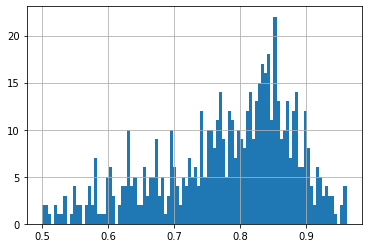

In [7]:
audience_metrics_confidence.apply(convert).hist(bins=100)

##### Rule: Audience inclusion only happens when `%` exceeds the expected rate (overall ~0.19)

Why? Most audiences are uncertain / fuzzy... so just include the "more confident than most" audiences

<AxesSubplot:>

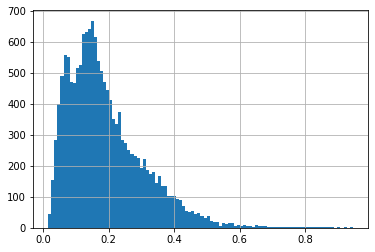

In [8]:
x = top_25_audience_report[[i for i in top_25_audience_report if i[-1] == '%']]
x.unstack().reset_index()[0].hist(bins=100)

##### Rule: Country inclusion only happens when `%` greater than 0.5
Why? The log distribution is bimodal... there are "low confidence" and "high confidence" countries

<AxesSubplot:>

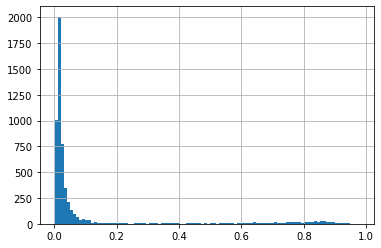

In [9]:
x = top_25_countries[[i for i in top_25_countries if i[-1] == '%']]
x.unstack().reset_index()[0].apply(convert).hist(bins=100)

##### Rule: Do not include cities... much too noisy
Why? The log distribution is very skewed and the confidence is very low in each observation

<AxesSubplot:>

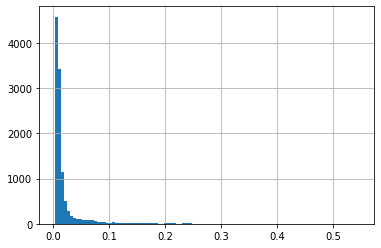

In [10]:
x = top_25_cities[[i for i in top_25_cities if i[-1] == '%']]
x.unstack().reset_index()[0].apply(convert).hist(bins=100)

##### Rule: Include profile interests
Why? They are balanced and plentiful... why not?

In [11]:
top_25_profile_interests.unstack().reset_index()[0].value_counts()

Fashion                            380
Travel, Tourism & Aviation         304
Beauty & Cosmetics                 297
Fitness                            289
Restaurants, Food & Grocery        287
Camera & Photography               266
Friends, Family & Relationships    240
Healthy Lifestyle                  230
Toys, Children & Baby              184
Music                              181
Electronics & Computers            167
Beer, Wine & Spirits               162
Television & Film                  155
Art & Design                       154
Activewear                         150
Sports                             149
Luxury Goods                       124
Pets                               124
Coffee, Tea & Beverages            120
Cars & Motorbikes                  107
Shopping & Retail                   92
Home Decor, Furniture & Garden      86
Jewellery & Watches                 79
Wedding                             72
Lifestyle                           54
Business & Careers       

##### Rule: Age inclusion only happens when `%` exceeds the expected rate (overall ~0.17)

Why? Most audiences are uncertain / fuzzy... so just include the "more confident than most" audiences

<AxesSubplot:>

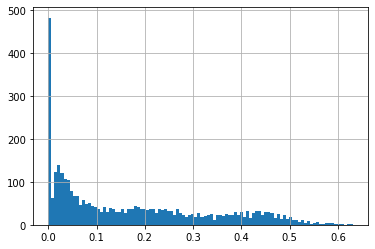

In [12]:
age_distribution[age_distribution>0].unstack().reset_index()[0].apply(convert).hist(bins=100)

##### Rule: Sex inclusion only happens when `%` exceeds the expected rate + 1 SD (>0.75)

Why? Most audiences are uncertain / fuzzy... so just include the "more confident than most" audiences

In [13]:
sex_distribution[sex_distribution>0].unstack().reset_index()[0].apply(convert).describe()

count    1228.000000
mean        0.500000
std         0.262539
min         0.022339
25%         0.278292
50%         0.500000
75%         0.721708
max         0.977661
Name: 0, dtype: float64

#### ETL on the original data to build GNN
- top_25_profile_interests  # INCLUDE (list of items per user)
- top_25_audience_report  # INCLUDE (tuples w/ percentages)
- age_distribution  # INCLUDE (list of percentages)

In [14]:
x = top_25_profile_interests.unstack()
x = x[x.notnull()].reset_index().drop('level_0', axis=1)
x.columns = ['user_id', 'interest_category']
x.to_csv(f'{PATH}/interest_categories.csv', index=None)

In [15]:
x1 = top_25_audience_report[[i for i in top_25_audience_report if i[-1] == '%']]
x2 = top_25_audience_report[[i for i in top_25_audience_report if i[-1] != '%']]

filter_audiences = x1 >= 0.19
filter_audiences.columns = [i[:-2] for i in filter_audiences.columns]

x3 = x2[filter_audiences].unstack()
x3 = x3[x3.notnull()].reset_index().drop('level_0', axis=1)
x3.columns = ['user_id', 'audience_category']
x3.to_csv(f'{PATH}/audience_categories.csv', index=None)


In [16]:
filter_ages = age_distribution >= 0.17
x = age_distribution[filter_ages]
x.columns = [i[:-2] for i in x.columns]
x = x.unstack()
x = x[x.notnull()].reset_index().drop(0, axis=1)
x.columns = ['age_category', 'user_id']
x.to_csv(f'{PATH}/age_categories.csv', index=None)